# Climatology of the forcings at PAPA selected stations

<div style="padding: 10px; border-radius: 5px; background-color: #cce5ff; color: #004085; border-left: 5px solid #007bff;">
    <strong>Note :</strong> We have a pteropods climatology for the 2° area 48.5->50.5N, -130.5->-128.5E and for the period September 1995 -> August 2020 <br>
    So, this notebook is preparing the forcing data in order to then optimise the ocean acidification seapopym model of pteropods.
</div>


## Set up

In [2]:
# imports
import xarray as xr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np 

<div style="padding: 10px; border-radius: 5px; background-color: #cce5ff; color: #004085; border-left: 5px solid #007bff;">
    <strong>Note :</strong> In a first time, the idea is to do a daily climatology. So we exclude 29 of February (leap years). <br> If later, we do a monthly climatology, maybe it will be better to take them into account.
</div>

In [3]:
# Create the mapping MM-DD -> day (except leap years)
days = pd.date_range('2001-01-01', '2001-12-31')  # 2001 not a leap year
mmdd_to_day = {d.strftime('%m-%d'): i+1 for i, d in enumerate(days)}


## Temperature Forcing climatology

<div class="alert alert-danger">
    <strong>Warning :</strong> huge amount of files = was run and save with forcings_daily_clim.py<br> + forcing available from 1998 -> ask if before available / or remove 1995 -> 1997 in pteropod climatology
</div>

In [6]:
path_temp="/data/rd_exchange/sroyer/SEAPOPYM/daily_temp_papa_1998_2020.nc"
ds_temp = xr.open_dataset(path_temp,engine='netcdf4')
path_clim_T="/data/rd_exchange/sroyer/SEAPOPYM/daily_clim_temp_papa_1998_2020.nc"
ds_clim_T = xr.open_dataset(path_clim_T,engine='netcdf4')


In [7]:
ds_temp

<xarray.Dataset> Size: 302kB
Dimensions:  (time: 8395)
Coordinates:
  * time     (time) datetime64[ns] 67kB 1998-01-01T12:00:00 ... 2020-12-31T12...
    day      (time) <U5 168kB ...
Data variables:
    T        (time) float64 67kB ...

In [8]:
ds_clim_T

<xarray.Dataset> Size: 10kB
Dimensions:  (day: 365)
Coordinates:
  * day      (day) <U5 7kB '01-01' '01-02' '01-03' ... '12-29' '12-30' '12-31'
Data variables:
    T        (day) float64 3kB ...

In [98]:
# Extract temperature and convert to pandas for plotting
temp = ds_temp['T']
clim = ds_clim_T['T']

# assign day coordinate in ds_temp
# Extract MM-DD 
mmdd = pd.to_datetime(temp.time.values).strftime('%m-%d')
# transform MM-DD in indice of day in year (1->365)
day_noleap = pd.Series(mmdd).map(mmdd_to_day).values
# add coord day
temp = temp.assign_coords(day=("time", day_noleap))

# for clim 
day_of_year= np.arange(1,366)
clim= clim.assign_coords(day_of_year=("day", day_of_year))

# Compute median
median_temp = temp.groupby('day').median('time')

#smooth median 
# Pad 15 days on each side cyclically
pad_width = 15
extended = xr.concat(
    [median_temp.isel(day=slice(-pad_width, None)),  # wrap end -> beginning
     median_temp,
     median_temp.isel(day=slice(0, pad_width))],     # wrap beginning -> end
    dim='day'
)

# Fix the 'day' coordinate (but for clarity)
extended['day'] = np.arange(-pad_width, 365 + pad_width)

# Apply the rolling mean
smoothed = extended.rolling(day=30, center=True).mean()

# Extract the center part (original days)
median_temp_smooth = smoothed.sel(day=slice(1, 365))


# Group by year
years = pd.DatetimeIndex(temp.time.values).year.unique()

fig = go.Figure()

# Plot one line per year
for year in years:
    yearly_data = temp.sel(time=str(year))
    fig.add_trace(go.Scatter(
        x=yearly_data['day'],
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black, thicker line
fig.add_trace(go.Scatter(
    x=clim['day_of_year'],
    y=clim.values,
    mode='lines',
    name='Climatology',
    line=dict(color='black', width=3)
))
#plot median in gray
fig.add_trace(go.Scatter(
    x=median_temp_smooth['day'],
    y=median_temp_smooth.values,
    mode='lines',
    name='Median',
    line=dict(color='grey', width=2)
))

fig.update_layout(
    title='Daily Temperature Time Series (1998-2020) and Climatology at PAPA',
    xaxis_title='Day of Year',
    yaxis_title='Temperature (degres Celcius)',
    template='plotly_white'
)

fig.show()


## Pelagic layer depth climatology

<div style="padding: 10px; border-radius: 5px; background-color: #cce5ff; color: #004085; border-left: 5px solid #007bff;">
    <strong>Note :</strong> It will be useful to convert unit btw model and observations.
</div>

In [ ]:
path_pld="/data/rd_exchange/sroyer/SEAPOPYM/daily_pelagiclayerdepth_papa_1998_2020.nc"
ds_pld = xr.open_dataset(path_pld,engine='netcdf4')
path_clim_pld="/data/rd_exchange/sroyer/SEAPOPYM/daily_clim_pelagiclayerdepth_papa_1998_2020.nc"
ds_clim_pld = xr.open_dataset(path_clim_pld,engine='netcdf4')

In [48]:
ds_pld

<xarray.Dataset> Size: 302kB
Dimensions:              (time: 8395)
Coordinates:
  * time                 (time) datetime64[ns] 67kB 1998-01-01T12:00:00 ... 2...
    day                  (time) <U5 168kB ...
Data variables:
    pelagic_layer_depth  (time) float64 67kB ...

In [49]:
ds_clim_pld

<xarray.Dataset> Size: 10kB
Dimensions:              (day: 365)
Coordinates:
  * day                  (day) <U5 7kB '01-01' '01-02' ... '12-30' '12-31'
Data variables:
    pelagic_layer_depth  (day) float64 3kB ...

In [99]:
# Extract pld 
pld = ds_pld['pelagic_layer_depth']
clim_pld = ds_clim_pld['pelagic_layer_depth']

# assign day coordinate in pld
# Extract MM-DD 
mmdd = pd.to_datetime(pld.time.values).strftime('%m-%d')
# transform MM-DD in indice of day in year (1->365)
day_noleap = pd.Series(mmdd).map(mmdd_to_day).values
# add coord day
pld = pld.assign_coords(day=("time", day_noleap))

# for clim 
day_of_year= np.arange(1,366)
clim_pld= clim_pld.assign_coords(day_of_year=("day", day_of_year))

#compute median
median_pld = pld.groupby('day').median('time')

#smooth median 
# Pad 15 days on each side cyclically
pad_width = 15
extended = xr.concat(
    [median_pld.isel(day=slice(-pad_width, None)),  # wrap end -> beginning
     median_pld,
     median_pld.isel(day=slice(0, pad_width))],     # wrap beginning -> end
    dim='day'
)

# Fix the 'day' coordinate (but for clarity)
extended['day'] = np.arange(-pad_width, 365 + pad_width)

# Apply the rolling mean
smoothed = extended.rolling(day=30, center=True).mean()

# Extract the center part (original days)
median_pld_smooth = smoothed.sel(day=slice(1, 365))

# Group by year
years = pd.DatetimeIndex(pld.time.values).year.unique()

fig = go.Figure()

# Plot one line per year
for year in years:
    yearly_data = pld.sel(time=str(year))
    fig.add_trace(go.Scatter(
        x=yearly_data['day'],
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black, thicker line
fig.add_trace(go.Scatter(
    x=clim_pld["day_of_year"],
    y=clim_pld.values,
    mode='lines',
    name='Climatology',
    line=dict(color='black', width=3)
))
# Plot median
fig.add_trace(go.Scatter(
    x=median_pld_smooth.day,
    y=median_pld_smooth.values,
    mode='lines',
    name='Median',
    line=dict(color='gray', width=2)
))
fig.update_layout(
    title='Daily Pelagic Layer Depth Time Series (1998-2020) and Climatology at PAPA',
    xaxis_title='Day of Year',
    yaxis_title='Pelagic Layer Depth (m)',
    template='plotly_white'
)

fig.show()


In [70]:
pld.mean()

<xarray.DataArray 'pelagic_layer_depth' ()> Size: 8B
array(81.7112306)

<div style="padding: 10px; border-radius: 5px; background-color: #cce5ff; color: #004085; border-left: 5px solid #007bff;">
    <strong>Note :</strong> The median don't smooth the climatology : keeping the mean seems better.
</div>

## Primary Productivity climatology

In [59]:
path_pp="/data/rd_exchange/sroyer/SEAPOPYM/daily_pp_papa_1998_2020.nc"
ds_pp = xr.open_dataset(path_pp,engine='netcdf4')
path_clim_pp="/data/rd_exchange/sroyer/SEAPOPYM/daily_clim_pp_papa_1998_2020.nc"
ds_clim_pp = xr.open_dataset(path_clim_pp,engine='netcdf4')

In [60]:
ds_pp

<xarray.Dataset> Size: 302kB
Dimensions:  (time: 8395)
Coordinates:
  * time     (time) datetime64[ns] 67kB 1998-01-01T12:00:00 ... 2020-12-31T12...
    day      (time) <U5 168kB ...
Data variables:
    npp      (time) float64 67kB ...

In [61]:
ds_clim_pp

<xarray.Dataset> Size: 10kB
Dimensions:  (day: 365)
Coordinates:
  * day      (day) <U5 7kB '01-01' '01-02' '01-03' ... '12-29' '12-30' '12-31'
Data variables:
    npp      (day) float64 3kB ...

VGPM 

In [100]:
# Extract net primary production
pp = ds_pp['npp']
clim_pp = ds_clim_pp['npp']

# assign day coordinate in pp
# Extract MM-DD 
mmdd = pd.to_datetime(pp.time.values).strftime('%m-%d')
# transform MM-DD in indice of day in year (1->365)
day_noleap = pd.Series(mmdd).map(mmdd_to_day).values
# add coord day
pp = pp.assign_coords(day=("time", day_noleap))

# for clim 
day_of_year= np.arange(1,366)
clim_pp= clim_pp.assign_coords(day_of_year=("day", day_of_year))

#compute median
median_pp = pp.groupby('day').median('time')

#smooth median 
# Pad 15 days on each side cyclically
pad_width = 15
extended = xr.concat(
    [median_pp.isel(day=slice(-pad_width, None)),  # wrap end -> beginning
     median_pp,
     median_pp.isel(day=slice(0, pad_width))],     # wrap beginning -> end
    dim='day'
)

# Fix the 'day' coordinate (but for clarity)
extended['day'] = np.arange(-pad_width, 365 + pad_width)

# Apply the rolling mean
smoothed = extended.rolling(day=30, center=True).mean()

# Extract the center part (original days)
median_pp_smooth = smoothed.sel(day=slice(1, 365))

# Group by year
years = pd.DatetimeIndex(pp.time.values).year.unique()

fig = go.Figure()

# Plot one line per year
for year in years:
    yearly_data = pp.sel(time=str(year))
    fig.add_trace(go.Scatter(
        x=yearly_data['day'],
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

# Plot climatology in black, thicker line
fig.add_trace(go.Scatter(
    x=clim_pp["day_of_year"],
    y=clim_pp.values,
    mode='lines',
    name='Climatology',
    line=dict(color='black', width=3)
))
# Plot median
fig.add_trace(go.Scatter(
    x=median_pp_smooth.day,
    y=median_pp_smooth.values,
    mode='lines',
    name='Median',
    line=dict(color='gray', width=2)
))
fig.update_layout(
    title='Daily Net Primary Production Time Series (1998-2020) and Climatology at PAPA',
    xaxis_title='Day of Year',
    yaxis_title='Net Primary Production (mg m-2 day-1)',
    template='plotly_white'
)

fig.show()


## pH Forcing climatology 

In [13]:
path_ph="/data/rd_exchange/amignot/CAREHEAT/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc"
ds_ph = xr.open_dataset(path_ph,engine='netcdf4')

In [14]:
ds_ph

<xarray.Dataset> Size: 3GB
Dimensions:          (time: 492, lat: 180, lon: 360, region: 4)
Coordinates:
  * time             (time) datetime64[ns] 4kB 1982-01-15 ... 2022-12-15
  * lat              (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * region           (region) <U7 112B 'global' 'north' 'tropics' 'south'
Data variables: (12/28)
    talk             (time, lat, lon) float32 128MB ...
    dic              (time, lat, lon) float32 128MB ...
    spco2            (time, lat, lon) float32 128MB ...
    sfco2            (time, lat, lon) float32 128MB ...
    ph_total         (time, lat, lon) float32 128MB ...
    ph_free          (time, lat, lon) float32 128MB ...
    ...               ...
    area             (lat, lon) float32 259kB ...
    fgco2_reg        (region, time) float32 8kB ...
    area_reg         (region) float32 16B ...
    ice              (time, lat, lon) float32 128MB ...
    kw               (time, lat, lon) float32 128MB ...
    sol              (time, lat, lon) float32 128MB ...
Attributes:
    contact:      gregorl@ethz.ch
    author:       Luke Gregor
    institution:  ETH Zuerich
    version:      v2023.GCB
    date:         2023-06-26
    description:  talk and pco2 (more accurately fco2) are estimated with two...
    changelog:    v2021d: Extended from 1982-2020; Now using: OISSTv2.1 for S...
    reference:    Gregor, L. and Gruber, N.: OceanSODA-ETHZ: A global gridded...
    source:       https://doi.org/10.25921/m5wx-ja34
    product:      OSETHZ-v2023.GCB

<div style="padding: 10px; border-radius: 5px; background-color: #d4edda; color: #155724; border-left: 5px solid #28a745;">
    <strong>Question:</strong> What is the difference btw total_pH and free_pH ?
</div>


In [15]:
# Select Papa zone + 1998/2020 to be coherent with other forcings
ds_pH_2deg = ds_ph.sel(
    lat=slice(48.5, 50.5),  
    lon=slice(-130.5, -128.5),
    time=slice('1998','2020')
).drop_dims('region')
ds_pH_2deg

<xarray.Dataset> Size: 251kB
Dimensions:          (time: 276, lat: 3, lon: 3)
Coordinates:
  * time             (time) datetime64[ns] 2kB 1998-01-15 ... 2020-12-15
  * lat              (lat) float64 24B 48.5 49.5 50.5
  * lon              (lon) float64 24B -130.5 -129.5 -128.5
Data variables: (12/26)
    talk             (time, lat, lon) float32 10kB ...
    dic              (time, lat, lon) float32 10kB ...
    spco2            (time, lat, lon) float32 10kB ...
    sfco2            (time, lat, lon) float32 10kB ...
    ph_total         (time, lat, lon) float32 10kB ...
    ph_free          (time, lat, lon) float32 10kB ...
    ...               ...
    sfco2_uncert     (time, lat, lon) float32 10kB ...
    fgco2            (time, lat, lon) float32 10kB ...
    area             (lat, lon) float32 36B ...
    ice              (time, lat, lon) float32 10kB ...
    kw               (time, lat, lon) float32 10kB ...
    sol              (time, lat, lon) float32 10kB ...
Attributes:
    contact:      gregorl@ethz.ch
    author:       Luke Gregor
    institution:  ETH Zuerich
    version:      v2023.GCB
    date:         2023-06-26
    description:  talk and pco2 (more accurately fco2) are estimated with two...
    changelog:    v2021d: Extended from 1982-2020; Now using: OISSTv2.1 for S...
    reference:    Gregor, L. and Gruber, N.: OceanSODA-ETHZ: A global gridded...
    source:       https://doi.org/10.25921/m5wx-ja34
    product:      OSETHZ-v2023.GCB

In [16]:
# Extract pH 
data_pH=ds_pH_2deg['ph_total']

In [17]:
# Spatial mean
data_pH=data_pH.mean(dim=['lat','lon'])

In [18]:
data_pH 

<xarray.DataArray 'ph_total' (time: 276)> Size: 1kB
array([8.096776 , 8.093139 , 8.103369 , 8.108756 , 8.124203 , 8.125215 ,
       8.117534 , 8.111247 , 8.105209 , 8.098011 , 8.097005 , 8.0881605,
       8.087761 , 8.085956 , 8.091503 , 8.099251 , 8.117567 , 8.126514 ,
       8.115099 , 8.116126 , 8.10572  , 8.095105 , 8.088471 , 8.085135 ,
       8.084554 , 8.079498 , 8.090031 , 8.099016 , 8.1187315, 8.123243 ,
       8.113781 , 8.112293 , 8.10607  , 8.0961275, 8.084854 , 8.077153 ,
       8.080849 , 8.0776205, 8.090754 , 8.101604 , 8.113761 , 8.12202  ,
       8.114953 , 8.110356 , 8.102858 , 8.096859 , 8.084327 , 8.079573 ,
       8.083331 , 8.077686 , 8.086521 , 8.099548 , 8.119112 , 8.121643 ,
       8.112087 , 8.108647 , 8.10312  , 8.094403 , 8.0801325, 8.080542 ,
       8.079464 , 8.07631  , 8.093357 , 8.103662 , 8.113145 , 8.117736 ,
       8.104547 , 8.1033325, 8.098724 , 8.094321 , 8.0833435, 8.075895 ,
       8.078078 , 8.071601 , 8.085969 , 8.094379 , 8.111439 , 8.113589 ,
       8.105133 , 8.097014 , 8.100618 , 8.095058 , 8.08334  , 8.074859 ,
       8.075088 , 8.0723   , 8.088498 , 8.098007 , 8.105394 , 8.111123 ,
       8.107221 , 8.0997505, 8.095419 , 8.086121 , 8.078799 , 8.06786  ,
       8.080703 , 8.065615 , 8.084568 , 8.093136 , 8.110509 , 8.111947 ,
       8.104919 , 8.10251  , 8.095413 , 8.087873 , 8.084322 , 8.067112 ,
       8.072923 , 8.072056 , 8.081529 , 8.088211 , 8.110614 , 8.112302 ,
       8.105603 , 8.104242 , 8.094527 , 8.083282 , 8.071043 , 8.067697 ,
...
       8.0983305, 8.095474 , 8.08741  , 8.080394 , 8.071255 , 8.055859 ,
       8.064479 , 8.059563 , 8.073201 , 8.080602 , 8.097249 , 8.106346 ,
       8.099904 , 8.093667 , 8.077795 , 8.066092 , 8.058518 , 8.059808 ,
       8.056211 , 8.057279 , 8.063685 , 8.077585 , 8.098088 , 8.101594 ,
       8.094558 , 8.090801 , 8.087583 , 8.069829 , 8.054352 , 8.048588 ,
       8.053966 , 8.055645 , 8.068178 , 8.076153 , 8.095074 , 8.103385 ,
       8.094068 , 8.085103 , 8.080507 , 8.073237 , 8.063047 , 8.055794 ,
       8.056159 , 8.052385 , 8.065279 , 8.078459 , 8.092464 , 8.089138 ,
       8.081356 , 8.081393 , 8.07869  , 8.073616 , 8.066492 , 8.055474 ,
       8.048037 , 8.048083 , 8.068377 , 8.072585 , 8.0920515, 8.089841 ,
       8.083313 , 8.082212 , 8.076127 , 8.064608 , 8.05475  , 8.049345 ,
       8.046096 , 8.048392 , 8.060295 , 8.069727 , 8.087146 , 8.087294 ,
       8.076008 , 8.077863 , 8.074009 , 8.066534 , 8.047931 , 8.033504 ,
       8.049067 , 8.044999 , 8.05199  , 8.070089 , 8.081036 , 8.084263 ,
       8.077514 , 8.0799265, 8.075809 , 8.058317 , 8.047142 , 8.044068 ,
       8.040792 , 8.041403 , 8.049153 , 8.068253 , 8.082221 , 8.084651 ,
       8.073017 , 8.07375  , 8.072283 , 8.060848 , 8.044933 , 8.039494 ,
       8.04793  , 8.038095 , 8.0511   , 8.061759 , 8.07206  , 8.083194 ,
       8.08198  , 8.075619 , 8.069034 , 8.064014 , 8.045982 , 8.033734 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-15 1998-02-15 ... 2020-12-15

In [ ]:
#data_pH.to_netcdf('/data/rd_exchange/sroyer/SEAPOPYM/monthly_pH_papa_1998_2020.nc')

In [19]:
# month coordinate in data_pH
data_pH['month'] = data_pH['time.month']

# Group by year
years = pd.DatetimeIndex(data_pH.time.values).year.unique()

fig = go.Figure()

# Plot one line per year
for year in years:
    yearly_data = data_pH.sel(time=str(year))
    fig.add_trace(go.Scatter(
        x=yearly_data['month'],
        y=yearly_data.values,
        mode='lines',
        line=dict(width=1),
        name=str(year),
        showlegend=True 
    ))

#plot median in black
median_pH = data_pH.groupby('month').median('time')

fig.add_trace(go.Scatter(
    x=median_pH['month'],
    y=median_pH.values,
    mode='lines',
    name='Median',
    line=dict(color='black', width=2)
))


fig.update_layout(
    title='Monthly pH Time Series (1998-2020) at PAPA',
    xaxis_title='Month',
    yaxis_title='pH (-log[H+])',
    template='plotly_white'
)

fig.show()


/tmp/ipykernel_1698376/1910003543.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



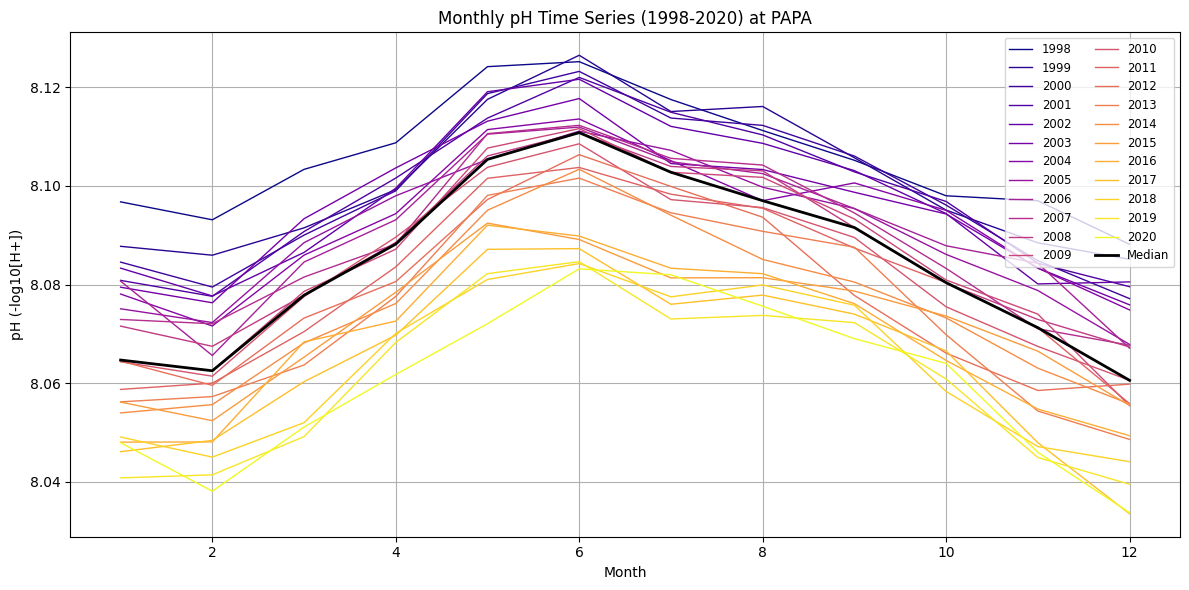

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Group by year
years = np.unique(pd.DatetimeIndex(data_pH.time.values).year)

# Create a colormap with as many colors as there are years
cmap = cm.get_cmap('plasma', len(years))
norm = mcolors.Normalize(vmin=years.min(), vmax=years.max())

# Plot one line per year with color from the colormap
for i, year in enumerate(years):
    yearly_data = data_pH.sel(time=str(year))
    color = cmap(i)  # or cmap(norm(year)) if using Normalize
    ax.plot(yearly_data['month'], yearly_data.values, linewidth=1, label=str(year), color=color)

ax.plot(median_pH['month'], median_pH.values, linewidth=2, label='Median', color='black')
# Axis labels and title
ax.set_title('Monthly pH Time Series (1998-2020) at PAPA')
ax.set_xlabel('Month')
ax.set_ylabel('pH (-log10[H+])')

# Add legend
ax.legend(loc='upper right', fontsize='small', ncol=2)

# Style and layout
ax.grid(True)
plt.tight_layout()
plt.show()


To have daily pH like the others forcings and to smooth the curve, lets fit the median with a Fourier serie function

In [105]:
median_pH.values

array([8.064691, 8.062519, 8.077848, 8.088211, 8.105394, 8.110822,
       8.102781, 8.097014, 8.09157 , 8.080394, 8.071255, 8.060577],
      dtype=float32)

In [43]:
from scipy.optimize import curve_fit

# Define mid-month day-of-year positions
mid_month_days = np.array([15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349])

x_date = mid_month_days 

# Median pH values for each month (12 values)
y_pH = median_pH.values

# Fourier series function 
def fourier_series(x, a0, a1, b1, a2, b2):
    return (a0 +
            a1 * np.cos(2 * np.pi * x / 365) + b1 * np.sin(2 * np.pi * x / 365) +
            a2 * np.cos(4 * np.pi * x / 365) + b2 * np.sin(4 * np.pi * x / 365))

# Fit Fourier model using normalized mid-month positions
params, _ = curve_fit(fourier_series, x_date, y_pH)

# Generate daily values
days = np.arange(365)
ph_daily = fourier_series(days, *params)

In [44]:
ph_daily

array([8.06115168, 8.06104656, 8.06094862, 8.06085798, 8.06077477,
       8.06069911, 8.06063111, 8.06057089, 8.06051856, 8.06047423,
       8.060438  , 8.06040998, 8.06039026, 8.06037893, 8.06037609,
       8.06038182, 8.06039621, 8.06041932, 8.06045124, 8.06049203,
       8.06054175, 8.06060046, 8.06066822, 8.06074507, 8.06083106,
       8.06092623, 8.0610306 , 8.06114421, 8.06126709, 8.06139923,
       8.06154067, 8.0616914 , 8.06185142, 8.06202072, 8.06219931,
       8.06238715, 8.06258422, 8.0627905 , 8.06300594, 8.06323052,
       8.06346417, 8.06370685, 8.0639585 , 8.06421906, 8.06448844,
       8.06476658, 8.0650534 , 8.06534879, 8.06565267, 8.06596495,
       8.0662855 , 8.06661422, 8.06695099, 8.06729569, 8.06764818,
       8.06800834, 8.06837603, 8.06875109, 8.06913337, 8.06952273,
       8.069919  , 8.07032202, 8.0707316 , 8.07114759, 8.07156979,
       8.07199803, 8.07243211, 8.07287184, 8.07331703, 8.07376746,
       8.07422294, 8.07468326, 8.07514821, 8.07561756, 8.07609

In [146]:
# Define mid-month day-of-year positions for plotting
mid_month_days = np.array([15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349])  # midpoints for Jan?Dec

fig = go.Figure()

# Plot one line (as dots) per year at mid-month positions
for year in years:
    yearly_data = data_pH.sel(time=str(year))
    fig.add_trace(go.Scatter(
        x=mid_month_days,
        y=yearly_data.values,
        #mode='markers',  # dots only
        mode='lines',
        #marker=dict(size=4),
        line=dict(width=1),
        name=str(year),
        showlegend=True
    ))

# Plot median in black dots
median_pH = data_pH.groupby('month').median('time')
fig.add_trace(go.Scatter(
    x=mid_month_days,
    y=median_pH.values,
    #mode='markers',
    mode='lines',
    line=dict(color='grey', width=3),
    name='Median'
))

# Add the interpolated Fourier daily curve
fig.add_trace(go.Scatter(
    x=np.arange(1, 366),  # day-of-year
    y=ph_daily,
    mode='lines',
    name='Fourier Interpolated Median',
    line=dict(color='black', width=3, dash='dash')
))

# Update layout
fig.update_layout(
    title='Monthly pH Time Series (1998-2020) at PAPA',
    xaxis_title='Date',
    yaxis_title='pH (-log[H+])',
    template='plotly_white',
    xaxis=dict(
        tickmode='array',
        tickvals=mid_month_days,
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
)

fig.show()


/tmp/ipykernel_1698376/3505523136.py:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



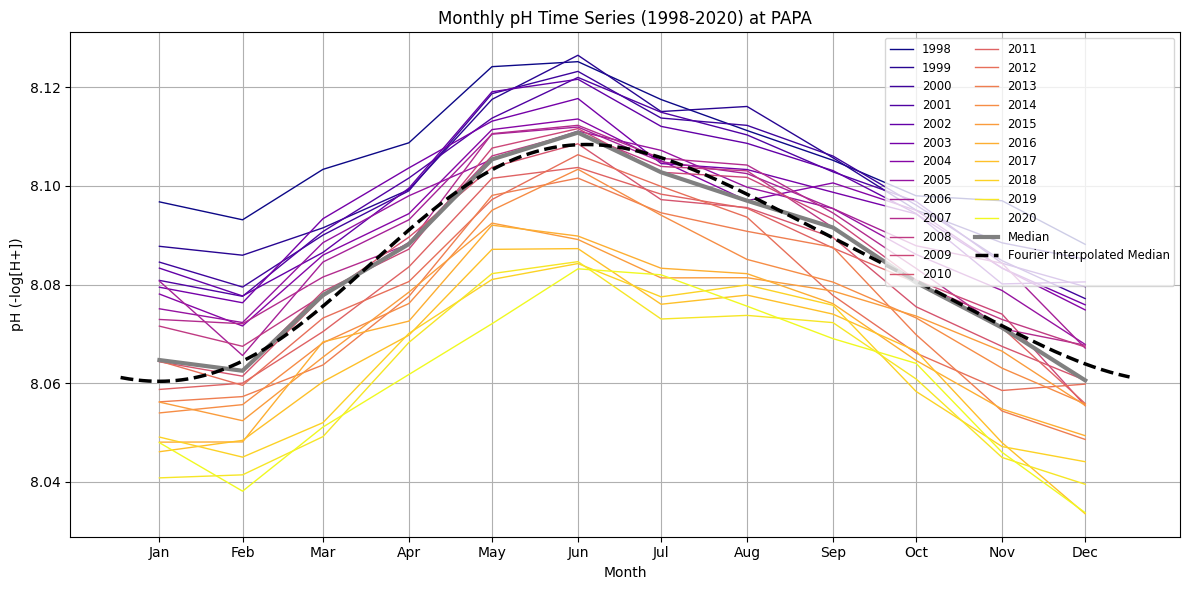

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# D�finir les milieux de mois (jours de l'ann�e)
mid_month_days = np.array([15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349])

# Extraire les ann�es
years = np.unique(pd.DatetimeIndex(data_pH.time.values).year)

# Cr�er la colormap
cmap = cm.get_cmap('plasma', len(years))

# Cr�er la figure
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les courbes annuelles
for i, year in enumerate(years):
    yearly_data = data_pH.sel(time=str(year))
    ax.plot(mid_month_days, yearly_data.values, color=cmap(i), linewidth=1, label=str(year))

# Tracer la m�diane mensuelle
median_pH = data_pH.groupby('month').median('time')
ax.plot(mid_month_days, median_pH.values, color='grey', linewidth=3, label='Median')

# Tracer la courbe interpol�e de Fourier
ax.plot(np.arange(1, 366), ph_daily, linestyle='--', color='black', linewidth=2.5, label='Fourier Interpolated Median')

# Personnalisation des axes
ax.set_title('Monthly pH Time Series (1998-2020) at PAPA')
ax.set_xlabel('Month')
ax.set_ylabel('pH (-log[H+])')
ax.set_xticks(mid_month_days)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# L�gende
ax.legend(loc='upper right', fontsize='small', ncol=2)

# Grille et mise en page
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# # Export interpolated daily values of  pH
# # Create a coordinate for the day of year (1 to 365)
# days = np.arange(1, 366)  # day 1 to 365

# # Create xarray DataArray
# ph_daily_da = xr.DataArray(
#     data=ph_daily,
#     coords={'days': days},
#     dims=['days'],
#     name='pH'
# )

# ph_daily_da.attrs['long_name'] = 'Interpolated daily pH'

# # Export to NetCDF
# ph_daily_da.to_netcdf('/data/rd_exchange/sroyer/SEAPOPYM/daily_acidity_papa_1998_2020.nc')


## Aragonite

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

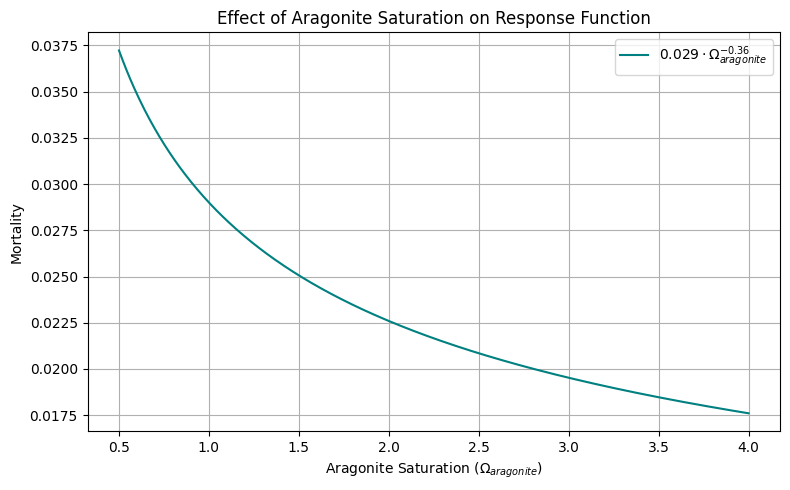

In [ ]:
# Define aragonite values
aragonite = np.linspace(0.5, 4, 500)

# Compute the function
y = 0.029 * aragonite**(-0.36)
A=np.linspace(0.0001, 0.1, 50)
B=np.linspace(-1, -0.00001, 50)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(aragonite, y, label=r'$0.029 \cdot \Omega_{aragonite}^{-0.36}$', color='teal')
# for a,b in zip(A,B):
#     plt.plot(aragonite,0.1*np.exp(aragonite*(b)))

plt.xlabel(r'Aragonite Saturation ($\Omega_{aragonite}$)')
plt.ylabel('Mortality')
plt.title('Effect of Aragonite Saturation on Response Function')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()